In [2]:
import statsmodels.api as sm

In [3]:
from pmdarima import auto_arima

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [4]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [6]:
import pandas as pd

In [31]:
df = pd.read_excel(r'D:\projects\SpendWise\data_internal\01-01-2024_31-12-2024.xls')

In [32]:
df['Date'] = pd.to_datetime(pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M:%S').dt.date)
df = df[['Date','Amount']]

In [33]:
df.set_index('Date', inplace=True)

In [34]:
df

,Amount
Date,
2024-07-01,300
2024-07-01,500
2024-06-29,90
2024-06-29,150
2024-06-28,135
...,...
2024-03-06,103
2024-03-04,37
2024-03-04,513


In [35]:
daily_expenses = df.resample('D').sum()
daily_expenses

,Amount
Date,
2024-03-01,15
2024-03-02,200
2024-03-03,0
2024-03-04,550
2024-03-05,0
...,...
2024-06-27,190
2024-06-28,135
2024-06-29,240


In [36]:
daily_expenses.index = pd.to_datetime(daily_expenses.index)

In [37]:
daily_expenses

,Amount
Date,
2024-03-01,15
2024-03-02,200
2024-03-03,0
2024-03-04,550
2024-03-05,0
...,...
2024-06-27,190
2024-06-28,135
2024-06-29,240


In [38]:
import matplotlib.pyplot as plt

In [39]:
print(daily_expenses.head())


            Amount
Date              
2024-03-01      15
2024-03-02     200
2024-03-03       0
2024-03-04     550
2024-03-05       0


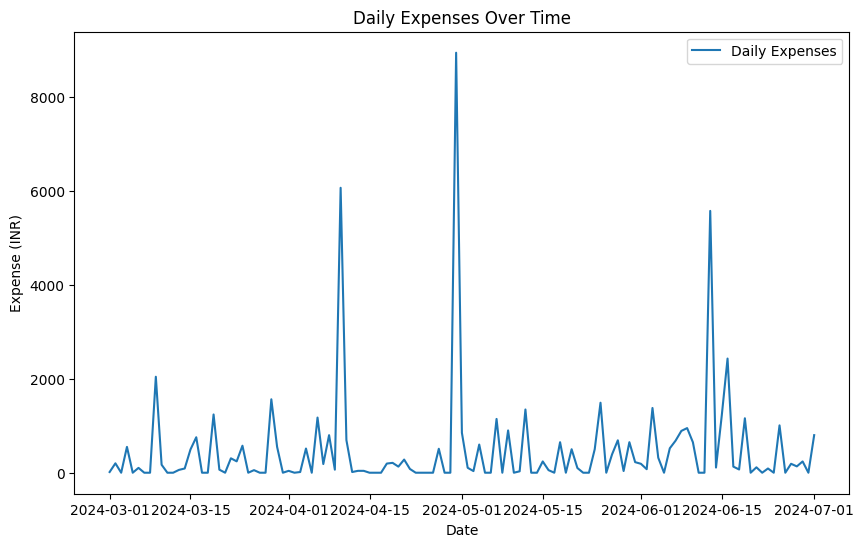

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(daily_expenses.index, daily_expenses.values, label='Daily Expenses')
plt.title('Daily Expenses Over Time')
plt.xlabel('Date')
plt.ylabel('Expense (INR)')
plt.legend()
plt.show()

In [41]:
result = adfuller(daily_expenses.dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -11.265211009503007
p-value: 1.5857421514937694e-20


In [42]:
if result[1] > 0.05:
    daily_expenses = daily_expenses.diff().dropna()

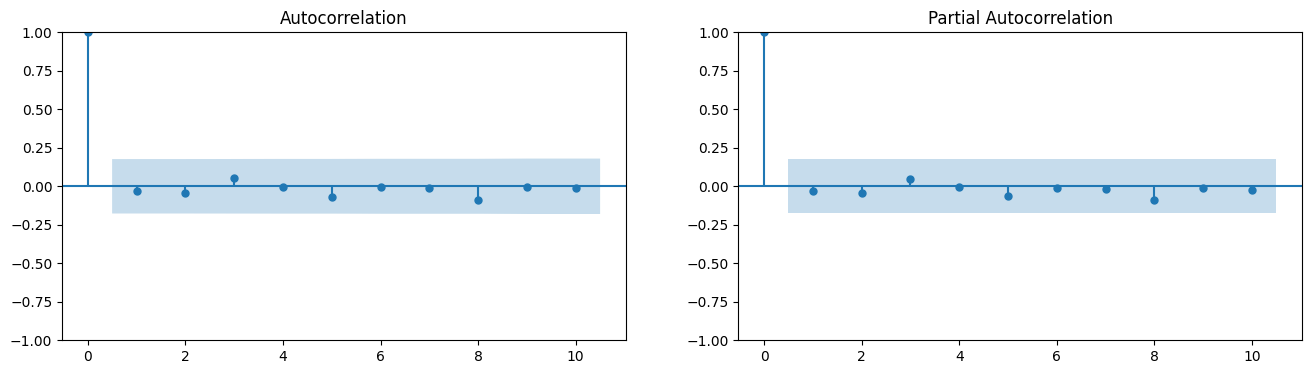

In [43]:
lags = min(10, len(daily_expenses) // 2 - 1)
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(daily_expenses, ax=axes[0], lags=lags)
plot_pacf(daily_expenses, ax=axes[1], lags=lags)
plt.show()

In [54]:
sarima_model = SARIMAX(daily_expenses, order=(1, 1, 1), seasonal_order=(1, 1, 1, 90))
sarima_result = sarima_model.fit(disp=False)
print(sarima_result.summary())

c:\Users\arjun\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


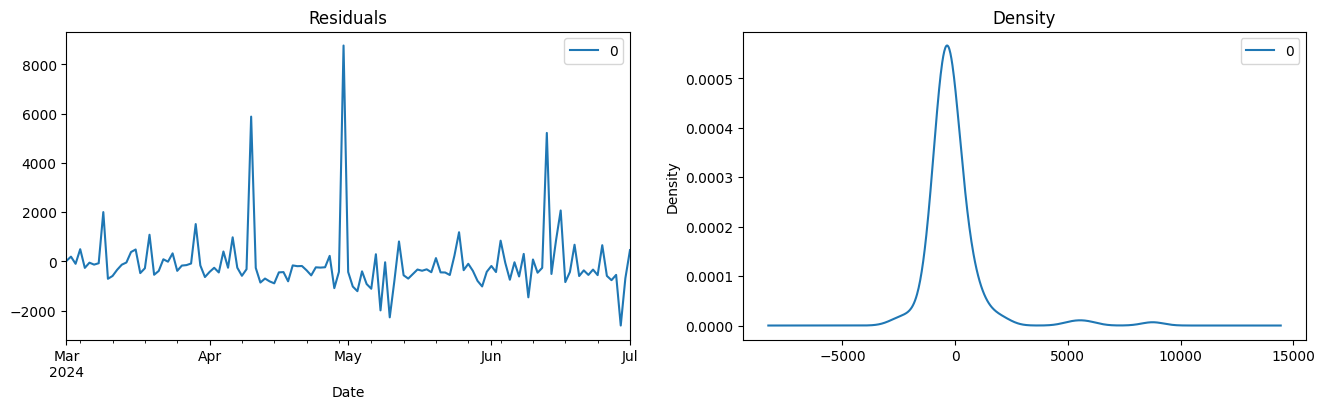

In [49]:
residuals = pd.DataFrame(sarima_result.resid)
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [52]:
n_periods = 40
forecast = sarima_result.get_forecast(steps=n_periods)
forecast_df = forecast.predicted_mean
conf_int = forecast.conf_int()


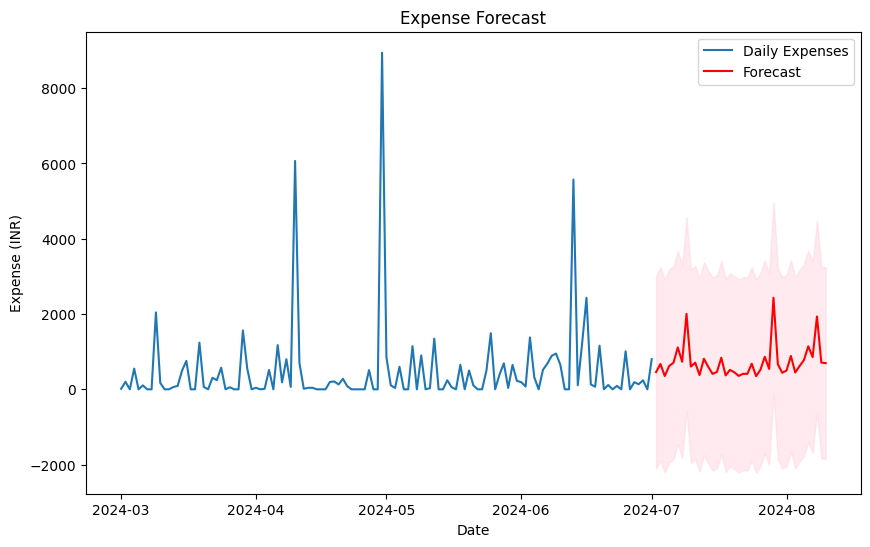

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(daily_expenses, label='Daily Expenses')
plt.plot(forecast_df, label='Forecast', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Expense Forecast')
plt.xlabel('Date')
plt.ylabel('Expense (INR)')
plt.legend()
plt.show()